In [17]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import json
from glob import glob
from PIL import Image


In [18]:

# 📁 Dossiers
image_dir_le = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM'
image_dir_sub = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM'
json_dir = 'CDD-CESM/json_output'
excel_path = 'processed_metadata.csv'


In [19]:

# 🔄 Fonction pour charger les images (8 vues par patient)
def load_image_stack(patient_id):
    paths = [
        f"{image_dir_le}/P{patient_id}_L_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_L_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_MLO.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_MLO.jpg",
    ]
    
    # Convertir chaque image en niveau de gris
    imgs = [np.array(Image.open(p).convert('L').resize((224, 224))) for p in paths]  # 'L' = grayscale
    stack = np.stack(imgs, axis=-1)  # (224, 224, 8)
    return stack / 255.0

# 🔢 Chargement et nettoyage des métadonnées
meta_df = pd.read_csv(excel_path)
meta_df = meta_df.dropna(subset=['Patient_ID', 'Pathology Classification/ Follow up'])
meta_df['Patient_ID'] = meta_df['Patient_ID'].astype(str)
print("Total patients dans le CSV :", len(meta_df))



Total patients dans le CSV : 2006


In [20]:

# --- Étape 1 : charger les rapports texte
texts = []
for pid in meta_df['Patient_ID']:
    path = os.path.join(json_dir, f"P{pid}.json")
    if os.path.exists(path):
        with open(path, encoding="utf-8") as f:
            try:
                d = json.load(f)
                flat_text = []
                for v in d.values():
                    flat_text.extend(map(str, v) if isinstance(v, list) else [str(v)])
                texts.append(" ".join(flat_text))
            except:
                texts.append("")
    else:
        texts.append("")


In [21]:

# --- Étape 2 : échantillonnage (80 % des patients)
sampled_df = meta_df.sample(frac=0.8, random_state=42)
sampled_patient_ids = sampled_df['Patient_ID'].astype(str).tolist()
print("Patients après échantillonnage 80% :", len(sampled_df))



Patients après échantillonnage 80% : 1605


In [22]:

# --- Étape 3 : charger les images
images = []
valid_labels = []
valid_pids = []
skipped_image = 0

for pid, label in zip(sampled_df['Patient_ID'], sampled_df['Pathology Classification/ Follow up']):
    try:
        img = load_image_stack(pid)
        images.append(img)
        valid_labels.append(label)
        valid_pids.append(pid)
    except:
        skipped_image += 1
        continue

print("Patients avec toutes les images :", len(valid_pids))
print("Patients ignorés à cause des images manquantes :", skipped_image)



Patients avec toutes les images : 1233
Patients ignorés à cause des images manquantes : 372


In [23]:

# --- Étape 4 : alignement des données
images = np.array(images)
image_patient_ids = set(valid_pids)
text_patient_ids = set(sampled_patient_ids)
metadata_patient_ids = set(meta_df['Patient_ID'])

common_patient_ids = list(image_patient_ids & text_patient_ids & metadata_patient_ids)

# Reconstruction des datasets filtrés
image_dict = {pid: img for pid, img in zip(valid_pids, images) if pid in common_patient_ids}
label_dict = {pid: label for pid, label in zip(valid_pids, valid_labels) if pid in common_patient_ids}
text_dict = {pid: text for pid, text in zip(sampled_patient_ids, texts) if pid in common_patient_ids}
meta_dict = {pid: meta_df[meta_df['Patient_ID'] == pid].iloc[0] for pid in common_patient_ids}

images_filtered = np.array([image_dict[pid] for pid in common_patient_ids])
labels_filtered = [label_dict[pid] for pid in common_patient_ids]
texts_filtered = [text_dict[pid] for pid in common_patient_ids]
meta_df_filtered = pd.DataFrame([meta_dict[pid] for pid in common_patient_ids])

empty_texts = sum([1 for text in texts if text.strip() == ""])
print("Textes vides ou invalides :", empty_texts)
print("Textes chargés au total :", len(texts))
print("Patients avec images, texte ET métadonnées :", len(common_patient_ids))




Textes vides ou invalides : 0
Textes chargés au total : 2006
Patients avec images, texte ET métadonnées : 193


In [24]:

# --- Étape 5 : vectorisation des textes
vectorizer = TfidfVectorizer(max_features=1000)
text_features_filtered = vectorizer.fit_transform(texts_filtered).toarray()


In [25]:

# --- Étape 6 : encodage des métadonnées
numerical = meta_df_filtered.select_dtypes(include=['float', 'int']).columns.tolist()
categorical = meta_df_filtered.select_dtypes(include=['object']).drop(columns=['Patient_ID', 'Pathology Classification/ Follow up']).columns.tolist()

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

meta_num_filtered = scaler.fit_transform(meta_df_filtered[numerical])
meta_cat_filtered = encoder.fit_transform(meta_df_filtered[categorical])
meta_features_filtered = np.concatenate([meta_num_filtered, meta_cat_filtered], axis=1)


In [36]:

# --- Étape 7 : encoder les labels
from collections import Counter
print("Distribution des labels avant filtrage :")
print(Counter(labels_filtered))

valid_labels_encoded, label_names = pd.factorize(labels_filtered)
labels_cat = to_categorical(valid_labels_encoded)


Distribution des labels avant filtrage :
Counter({'Malignant': 69, 'Normal': 68, 'Benign': 56})


/tmp/ipykernel_12421/3972621712.py:6: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  valid_labels_encoded, label_names = pd.factorize(labels_filtered)


In [27]:

# --- Étape 8 : vérification finale
assert len(images_filtered) == len(meta_features_filtered) == len(text_features_filtered) == len(labels_cat)

print("✅ Données bien alignées :", len(images_filtered), "exemples valides")


✅ Données bien alignées : 193 exemples valides


In [28]:

## 🧠 Architecture du modèle multimodal
img_input = Input(shape=(224, 224, 8))
meta_input = Input(shape=(meta_features_filtered.shape[1],))
text_input = Input(shape=(text_features_filtered.shape[1],))

# Image branch
x_img = Conv2D(32, (3, 3), activation='relu')(img_input)
x_img = MaxPooling2D()(x_img)
x_img = Conv2D(64, (3, 3), activation='relu')(x_img)
x_img = GlobalAveragePooling2D()(x_img)

# Metadata branch
x_meta = Dense(64, activation='relu')(meta_input)

# Text branch
x_text = Dense(64, activation='relu')(text_input)

# Fusion
x = Concatenate()([x_img, x_meta, x_text])
x = Dense(128, activation='relu')(x)
output = Dense(len(label_names), activation='softmax')(x)

model = Model(inputs=[img_input, meta_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 222, 222,  │      2,336 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 111, 111,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 381)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 272)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     24,448 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     17,472 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     24,704 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        387 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,843 (343.14 KB)

 Trainable params: 87,843 (343.14 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:

## 🚂 Entraînement
# Étape 1 : split train + test
X_img_temp, X_img_test, X_meta_temp, X_meta_test, X_txt_temp, X_txt_test, y_temp, y_test = train_test_split(
    images_filtered, meta_features_filtered, text_features_filtered, labels_cat,
    test_size=0.1, random_state=42
)

# Étape 2 : split train + val
X_img_train, X_img_val, X_meta_train, X_meta_val, X_txt_train, X_txt_val, y_train, y_val = train_test_split(
    X_img_temp, X_meta_temp, X_txt_temp, y_temp,
    test_size=0.2, random_state=42
)


history = model.fit(
    [X_img_train, X_meta_train, X_txt_train], y_train,
    validation_data=([X_img_val, X_meta_val, X_txt_val], y_val),
    epochs=10,
    batch_size=16
)



Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - accuracy: 0.3970 - loss: 1.0806 - val_accuracy: 0.2000 - val_loss: 1.1666
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 418ms/step - accuracy: 0.4134 - loss: 1.0328 - val_accuracy: 0.4000 - val_loss: 1.1398
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - accuracy: 0.5405 - loss: 0.9755 - val_accuracy: 0.4000 - val_loss: 1.1387
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - accuracy: 0.5680 - loss: 0.9014 - val_accuracy: 0.4286 - val_loss: 1.1652
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - accuracy: 0.6575 - loss: 0.8262 - val_accuracy: 0.4286 - val_loss: 1.1794
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 0.6789 - loss: 0.7782 - val_accuracy: 0.4571 - val_loss: 1.2116
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - accuracy: 0.7059 - loss: 0.6674 - val_accuracy: 0.4571 - val_loss: 1.2059
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.7612 - loss: 0.5942 - val_accuracy: 0.5143 - val_loss:

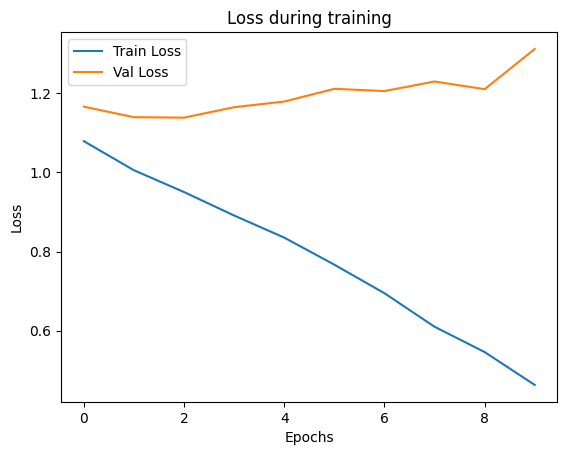

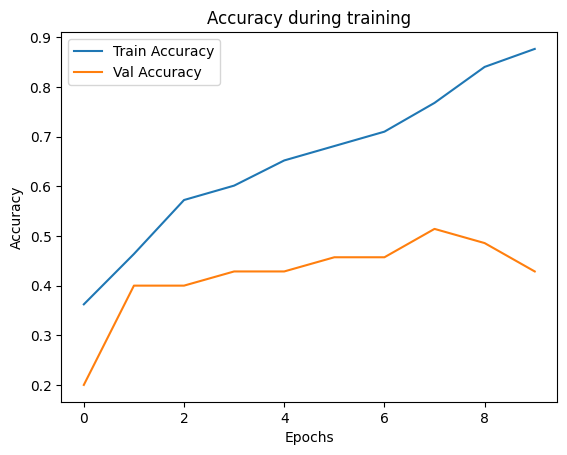

In [30]:
import matplotlib.pyplot as plt

# Affichage de la loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Affichage de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
              precision    recall  f1-score   support

   Malignant       0.27      0.75      0.40         4
      Benign       0.50      0.14      0.22         7
      Normal       0.29      0.22      0.25         9

    accuracy                           0.30        20
   macro avg       0.35      0.37      0.29        20
weighted avg       0.36      0.30      0.27        20

F1-score (weighted): 0.27027777777777773
Accuracy: 0.3


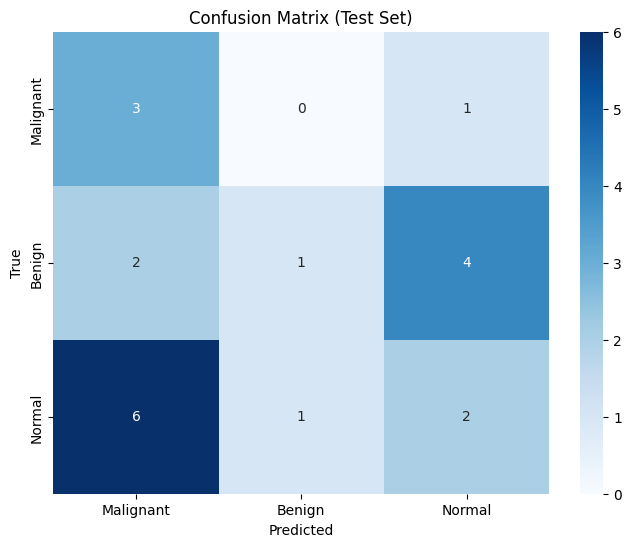

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
import numpy as np

# Prédictions sur le test set
y_pred_proba = model.predict([X_img_test, X_meta_test, X_txt_test])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Affichage du rapport
print(classification_report(y_true, y_pred, target_names=label_names))

# F1, accuracy
print("F1-score (weighted):", f1_score(y_true, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_true, y_pred))

# Matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [32]:
from sklearn.preprocessing import label_binarize

# Binarisation des labels
y_test_bin = label_binarize(y_true, classes=range(len(label_names)))
y_pred_bin = y_pred_proba  # déjà en proba

auc_score = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')
print("ROC AUC (macro, one-vs-rest):", auc_score)


ROC AUC (macro, one-vs-rest): 0.4960583398083398
